## Dataset and configuration selection

In [1]:
import re
import pandas as pd
from pathlib import Path
import os

In [5]:
from utils import construct_instance_log_dict
partition = "validation"
dataset = "MIS"
configuration_selected = "full"

if configuration_selected=="param":#param
    network = "graph_with_variables_2_GCN"
    method = "thresholded_expected_error"
elif configuration_selected=="net":#net
    method = "fixed_three_ratios"
    network = "graph_with_literals_8_GTR"
elif configuration_selected=="v0":#v0
    method = "fixed_three_ratios"
    network = "graph_with_variables_2_GCN"
elif configuration_selected=="full":#v1
    method = "thresholded_expected_error"
    network = "graph_with_literals_8_GTR"
else:
    raise Exception("Unknown configuration selected.")

base_path = f"../wkdir/{dataset}/{partition}"

methods_paths = []

backpas_network_method_paths = f"{base_path}/{network}/trust_region_{method}"
backpas_network_method_paths = Path(backpas_network_method_paths)
methods_paths += [method_path for method_path in backpas_network_method_paths.iterdir() if method_path.is_dir() and not method_path.name.endswith("_log")]


baseline_path = Path(f"{base_path}/baseline")

instance_log_dict = construct_instance_log_dict(
    baseline_path=baseline_path,
    methods_paths=methods_paths
)

Method threshold_0.6195292171656754_alpha_-0.8583122031751258 has 0 instances with timeout.
Method threshold_0.7005754117124776_alpha_-0.9301224002409993 has 0 instances with timeout.
Method threshold_0.6020447847458135_alpha_-0.9975726732882004 has 0 instances with timeout.
Method threshold_0.7486794870581196_alpha_-0.9789699585606592 has 0 instances with timeout.
Method threshold_0.9162213197353256_alpha_-0.5753217788557868 has 0 instances with timeout.
Method threshold_0.5891440435849862_alpha_-0.9929676196327426 has 0 instances with timeout.
Method threshold_0.728034992196378_alpha_0.5703519220008513 has 0 instances with timeout.
Method threshold_0.6667044566672099_alpha_-0.8645450959318701 has 0 instances with timeout.
Method threshold_0.6215895160653434_alpha_-0.48904694607905963 has 0 instances with timeout.
Method threshold_0.6521211218712843_alpha_0.04951286273971922 has 0 instances with timeout.
Method threshold_0.6920670347249327_alpha_-0.7445283892835002 has 0 instances wit

## Checking missing logs

In [ ]:
missing_logs = []
for instance_name, instance_log in instance_log_dict.items():
    for method_name, log_file_path in instance_log.items():
        if not log_file_path.exists():
            instance_path = log_file_path.parent.parent / log_file_path.parent.name.replace("_log", "") / log_file_path.name.replace(".log", "")
            missing_logs.append((instance_name, method_name, log_file_path, instance_path))

In [7]:
df_aux = pd.DataFrame(missing_logs, columns=["instance", "method", "log_file_path","instance_path"])
df_aux.groupby("method")["log_file_path"].count().sort_values(ascending=False)

Series([], Name: log_file_path, dtype: int64)

In [8]:
from utils import create_temp_file_list
if len(missing_logs)>0:
    file_paths = set()
    for instance_name, method_name, log_file_path, instance_path in missing_logs:
        file_paths.add(instance_path)
    file_paths = list(file_paths)
    aux = input("Enter step")
    output_filename = Path(base_path) / f"{configuration_selected}_step_{aux}.txt"
    #print(len(file_paths),output_filename)
    aux = input(f"The file {output_filename} will be created with {len(file_paths)} instances. Press OK to confirm")
    if aux =="ok":
        create_temp_file_list(file_paths, output_filename=str(output_filename))
    else:
        raise Exception("File not created due to lack of confirmation")
else:
    print("You can continue")

You can continue


## Reading logs

In [12]:
from utils import get_all_logs_for_instance
if dataset=="MVC":
    objective="min"
elif dataset=="MIS" or dataset == "MIS-mixed-train" or dataset=="CA":
    objective="max"
else:
    raise ValueError("Objective sense not defined for this dataset: ",dataset)

df_primal_integral,_ = get_all_logs_for_instance(instance_log_dict, objective=objective)

## CSV update/creation

In [13]:
if method == "fixed_three_ratios":
    def parse_name(method_name,param_name):
        #method_name with format f"k_{k_ratio}_value_0_{value_0_ratio}_delta_{delta_ratio}" 
        parts = method_name.split("_")
        if param_name == "k_ratio":
            return parts[1]
        if param_name == "value_0_ratio":
            return parts[4]
        if param_name == "Delta_ratio":
            return parts[6]
    df_primal_integral_validation = df_primal_integral[~df_primal_integral["method"].isin(["baseline", "conpas_paper"])].copy()
    df_primal_integral_validation["k_ratio"] = df_primal_integral_validation["method"].apply(lambda x: parse_name(x,"k_ratio"))
    df_primal_integral_validation["value_0_ratio"] = df_primal_integral_validation["method"].apply(lambda x: parse_name(x,"value_0_ratio"))
    df_primal_integral_validation["Delta_ratio"] = df_primal_integral_validation["method"].apply(lambda x: parse_name(x,"Delta_ratio"))
    computed_results = df_primal_integral_validation.groupby(["k_ratio","value_0_ratio","Delta_ratio"])["primal_integral"].mean().sort_values().reset_index().rename(columns={"primal_integral": "objective_value"}).sort_values("objective_value")
elif method == "thresholded_expected_error":
    def parse_name(method_name,param_name):
        #method_name with format f"thresholded_expected_error_{threshold}" 
        parts = method_name.split("_")
        if param_name == "threshold":
            return parts[1]
        if param_name == "alpha":
            return parts[3]
    df_primal_integral_validation = df_primal_integral[~df_primal_integral["method"].isin(["baseline", "conpas_paper"])].copy()
    df_primal_integral_validation["threshold"] = df_primal_integral_validation["method"].apply(lambda x: parse_name(x,"threshold"))
    df_primal_integral_validation["alpha"] = df_primal_integral_validation["method"].apply(lambda x: parse_name(x,"alpha"))
    computed_results = df_primal_integral_validation.groupby(["threshold","alpha"])["primal_integral"].mean().sort_values().reset_index().rename(columns={"primal_integral": "objective_value"}).sort_values("objective_value")
else:
    raise Exception("Method nor recognized")

In [14]:
empty_method_counter = {}
for instance_name in instance_log_dict:
    for method_name in instance_log_dict[instance_name]:
        if method_name == "baseline":
            continue
        if method_name not in empty_method_counter:
            empty_method_counter[method_name] = 0
        if instance_log_dict[instance_name][method_name] != instance_log_dict[instance_name]["baseline"]:
            empty_method_counter[method_name] += 1


In [15]:
empty_methods = []
for method_name in empty_method_counter:
    if empty_method_counter[method_name]==0:
        empty_methods.append(method_name)
assert len(empty_methods)==0 
print("No empty methods")

No empty methods


In [16]:
computed_results.head()

,threshold,alpha,objective_value
0,0.6161128065675395,-0.9946887313825645,0.883434
1,0.6165030895934848,-0.9933755762788179,1.299944
2,0.5649859227048586,-0.9048915094761303,1.307587
3,0.5891440435849862,-0.9929676196327426,1.396540
4,0.6711719863441881,-0.9400597766810709,1.435326


In [17]:
results_path = backpas_network_method_paths / "results.csv"
df_trials = pd.read_csv(results_path)
def get_step(params):
    epsilon = 1e-6
    mask = None
    for name_param,value in params.items():
        if mask is None:
            mask = (df_trials[name_param].astype(float) - float(value)).abs() < epsilon    
        else:
            mask &= (df_trials[name_param].astype(float) - float(value)).abs() < epsilon
    selected=df_trials.loc[mask, "step"]
    assert selected.shape[0] == 1, f"More than one step found for {params}"
    return selected.values[0] if selected.shape[0] == 1 else None
print("Reading results.csv from",results_path)
print("Number of trials found", len(df_trials), " Incomplete trials found ",df_trials["objective_value"].isna().sum())

Reading results.csv from ../wkdir/MIS/validation/graph_with_literals_8_GTR/trust_region_thresholded_expected_error/results.csv
Number of trials found 60  Incomplete trials found  0


In [18]:
if method == "fixed_three_ratios":
    def get_params(row):
        return {
            "k_ratio": row["k_ratio"],
            "value_0_ratio": row["value_0_ratio"],
            "Delta_ratio": row["Delta_ratio"]
        }
elif method == "thresholded_expected_error":
    def get_params(row):
        return {
            "threshold": row["threshold"],
            "alpha": row["alpha"]
        }
else:
    raise Exception("Method nor recognized")
computed_results["step"] = computed_results.apply(lambda row: get_step(get_params(row)), axis=1)
computed_results.head()

,threshold,alpha,objective_value,step
0,0.6161128065675395,-0.9946887313825645,0.883434,3
1,0.6165030895934848,-0.9933755762788179,1.299944,3
2,0.5649859227048586,-0.9048915094761303,1.307587,3
3,0.5891440435849862,-0.9929676196327426,1.396540,1
4,0.6711719863441881,-0.9400597766810709,1.435326,2


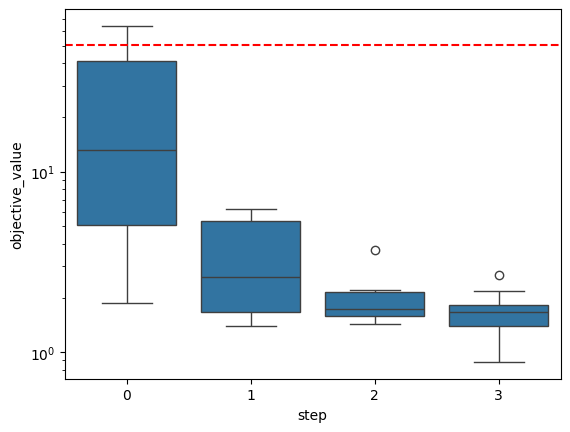

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=computed_results, x="step", y="objective_value")
#pllot hline
plt.axhline(y=df_primal_integral[df_primal_integral["method"]=="baseline"]["primal_integral"].mean(), color='r', linestyle='--', label='Gurobi')
if len(df_primal_integral[df_primal_integral["method"]=="conpas_paper"])!=0:
    #plot the ConPaS paper line only if it exists
    plt.axhline(y=df_primal_integral[df_primal_integral["method"]=="conpas_paper"]["primal_integral"].mean(), color='g', linestyle='--', label='ConPaS paper')
plt.yscale("log")
plt.show()

In [20]:
save_results = True
if save_results:
    if len(df_primal_integral[df_primal_integral["method"]=="conpas_paper"])!=0:
        raise ValueError("conpas_paper method is not empty. Please check the results before saving.")
    computed_results.to_csv(results_path, index=False)
    print("Results saved to ",results_path)

Results saved to  ../wkdir/MIS/validation/graph_with_literals_8_GTR/trust_region_thresholded_expected_error/results.csv
